In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys

sys.path.append('../')
from models.model import prob_nn, vanilla_nn
from datasets.synth import oneD_linear

import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy
# from tqdm import tqdm
from tqdm.notebook import tqdm

import torch
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

In [3]:
def softplus( x):
    softplus = torch.log(1+torch.exp(x))
    softplus = torch.where(softplus == float('inf'), x, softplus)
    return softplus

In [4]:
gpu_num = 0

In [5]:
cuda_device = "cuda:{}".format(gpu_num)
use_cuda = torch.cuda.is_available()
device = torch.device(cuda_device if use_cuda else "cpu")
print('Using device ', device)

Using device  cuda:0


## Test on a single network first

In [43]:
temp_pnn = prob_nn(hidden_size = 16, num_layers = 2)
temp_X = torch.tensor([[-1], [1]]).float()
temp_y = torch.tensor([[-1], [1]]).float()
temp_opt = optim.Adam(temp_pnn.parameters(), lr=1e-3)

for ep in range(10000):
    temp_opt.zero_grad()
    pred = temp_pnn(temp_X)
    loss = temp_pnn.loss(pred, temp_y)
    if ep % 50 == 0:
        print(ep, loss.item())
    loss.backward()
    temp_opt.step()

0 0.7211815118789673
50 0.3218690752983093
100 0.028741449117660522
150 -0.2564341425895691
200 -0.5560991764068604
250 -0.8634005784988403
300 -1.1673859357833862
350 -1.492492914199829
400 -1.8612167835235596
450 -2.2841057777404785
500 -2.748258590698242
550 -3.2319443225860596
600 -3.7040159702301025
650 -4.119478702545166
700 -4.484511852264404
750 -4.88748025894165
800 -5.395717144012451
850 -5.647253513336182
900 -5.856879711151123
950 -5.597357749938965
1000 -6.249387264251709
1050 -6.377039909362793
1100 -6.365279674530029
1150 -6.411447048187256
1200 -6.76638650894165
1250 -6.9474778175354
1300 -6.9378557205200195
1350 -6.272887229919434
1400 -6.9202423095703125
1450 -7.0736870765686035
1500 -5.776202201843262
1550 -7.277929306030273
1600 -6.873577117919922
1650 -7.137105941772461
1700 -7.248597621917725
1750 -7.056233882904053
1800 -7.120451927185059
1850 -7.222259044647217
1900 -7.278045654296875
1950 -7.349966049194336
2000 -7.421885013580322
2050 -7.421886444091797
2100 -

KeyboardInterrupt: 

In [ ]:
temp_betw = torch.linspace(-10,10,1000).view(-1,1)
with torch.no_grad():
    mean, var = torch.split(temp_pnn(temp_betw), 1, dim=1)
    var = temp_pnn.softplus(var)
    std = torch.sqrt(var)
plt.plot(temp_betw.flatten(), mean.flatten())
plt.fill_between(temp_betw.flatten(), (mean-std).flatten(), (mean+std).flatten())
# plt.ylim(-1,1)
# plt.xlim(-1,1)

## Make ensemble of PNN

In [6]:
train_set = oneD_linear(size=2)
train_gen = DataLoader(train_set)
train_X = torch.tensor([[-1], [1]]).to(device).float()
train_y = torch.tensor([[-1], [1]]).to(device).float()

In [7]:
num_nets = 30

In [8]:
lr = 1e-2
thresh = -3
same_list_count_thresh = 20
max_epochs = int(1e6)
saved_models = {}

In [9]:
num_l_list = [2, 3]
hidden_s_list = [8, 16]

# num_l_list = [2, 3, 5]
# hidden_s_list = [8, 16, 32]

# num_l_list = [10]
# hidden_s_list = [32]
# num_l_list = [2, 3, 5, 10, 20, 50]
# hidden_s_list = [8, 16, 32, 64, 128]

In [10]:
for num_l in num_l_list:
    for hidden_s in hidden_s_list:
        print('Doing {} layers, {} hidden now'.format(num_l, hidden_s))
        nets = [prob_nn(hidden_size=hidden_s, num_layers=num_l).to(device) for x in range(num_nets)]
        opts = [optim.Adam(x.parameters(), lr=lr) for x in nets]
        need_training = [i for i in range(num_nets)]
        prev_need_training = deepcopy(need_training)
        same_list_count = 0
        
        for epoch in tqdm(range(max_epochs)):
            for idx in range(num_nets):
                if idx not in need_training:
                    continue
                opts[idx].zero_grad()
                batch_pred = nets[idx](train_X)
                loss = nets[idx].loss(batch_pred, train_y)

                if loss.item() < thresh:
#                         print('{}, {}, removing {}'.format(num_l, hidden_s, idx))
                    need_training.remove(idx)
                    continue

                loss.backward()
                opts[idx].step()
            if len(need_training) == 0:
                break
            if epoch % 50 == 0:
                print('{0} layers, {1} hidden : epoch {2} loss {3:.5f}'.format(num_l, hidden_s, epoch, loss.item()))
                print('Need to train {} nets'.format(len(need_training)))
                print(need_training, '\n')
                
                if prev_need_training == need_training:
                    same_list_count += 1
                else:
                    same_list_count = 0
                    
                prev_need_training = deepcopy(need_training)
                
                if same_list_count > same_list_count_thresh:
                    print('The following nets are stuck, breaking {}'.format(need_training))
                    for stuck_idx in need_training:
                        nets[stuck_idx] = None
                    saved_models[(num_l, hidden_s)] = nets
                    break
        print('Num layers {}, hiddden size {} done'.format(num_l, hidden_s))    
        saved_models[(num_l, hidden_s)] = nets

Doing 2 layers, 8 hidden now


2 layers, 8 hidden : epoch 0 loss 1.00944
Need to train 30 nets
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] 

2 layers, 8 hidden : epoch 50 loss -1.09043
Need to train 30 nets
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] 

2 layers, 8 hidden : epoch 100 loss -2.33269
Need to train 22 nets
[0, 1, 2, 3, 5, 6, 8, 9, 10, 11, 13, 16, 17, 18, 19, 20, 21, 22, 25, 26, 27, 29] 

2 layers, 8 hidden : epoch 150 loss -2.36756
Need to train 4 nets
[0, 9, 18, 26] 

2 layers, 8 hidden : epoch 200 loss -2.69572
Need to train 4 nets
[0, 9, 18, 26] 

2 layers, 8 hidden : epoch 250 loss -2.59101
Need to train 3 nets
[0, 9, 18] 

2 layers, 8 hidden : epoch 300 loss -1.87242
Need to train 1 nets
[0] 

2 layers, 8 hidden : epoch 350 loss -2.00444
Need to train 1 nets
[0] 

2 layers, 8 hidden : epoch 400 loss -2.14486
Need to train 1 nets
[0] 

2 layers, 8 hidden : epoch 450 lo

2 layers, 16 hidden : epoch 0 loss 0.40212
Need to train 30 nets
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] 

2 layers, 16 hidden : epoch 50 loss -1.70832
Need to train 30 nets
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] 

2 layers, 16 hidden : epoch 100 loss -2.71356
Need to train 1 nets
[20] 

Num layers 2, hiddden size 16 done
Doing 3 layers, 8 hidden now



3 layers, 8 hidden : epoch 0 loss 0.53380
Need to train 30 nets
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] 

3 layers, 8 hidden : epoch 50 loss -1.37145
Need to train 29 nets
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] 

3 layers, 8 hidden : epoch 100 loss -2.89959
Need to train 6 nets
[1, 4, 17, 19, 27, 29] 

3 layers, 8 hidden : epoch 150 loss -1.82936
Need to train 4 nets
[1, 4, 17, 27] 

3 layers, 8 hidden : epoch 200 loss -1.96426
Need to train 3 nets
[1, 4, 27] 

3 layers, 8 hidden : epoch 250 loss -2.48917
Need to train 2 nets
[4, 27] 

3 layers, 8 hidden : epoch 300 loss -1.11051
Need to train 2 nets
[4, 27] 

3 layers, 8 hidden : epoch 350 loss -1.28302
Need to train 2 nets
[4, 27] 

3 layers, 8 hidden : epoch 400 loss -1.38270
Need to train 2 nets
[4, 27] 

3 layers, 8 hidden : epoch 450 loss -1.49696
Need to train 2 nets
[4, 27] 

3 layers, 8 hid

3 layers, 16 hidden : epoch 0 loss 0.47279
Need to train 30 nets
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29] 

3 layers, 16 hidden : epoch 50 loss -1.76807
Need to train 14 nets
[0, 1, 2, 4, 7, 8, 10, 15, 18, 19, 21, 22, 24, 28] 

Num layers 3, hiddden size 16 done


In [11]:
in_betw = torch.linspace(-10, 10, 1000).view(-1,1).to(device).float()

In [13]:
for key in saved_models.keys():
    for model in saved_models[key]:
        if model is not None:
            temp_pred = model(train_X.to(device))
            loss = model.loss(temp_pred, train_y.to(device)).item()
            assert(loss < -3)
#             print('{0:.2f}'.format(model.loss(temp_pred, temp_y.to(device)).item()))

In [14]:
results = {}
for key,nets in saved_models.items():
    with torch.no_grad():
        outputs = [x(in_betw) for x in nets if x is not None]
        results[key] = outputs

## Plot mean predictions

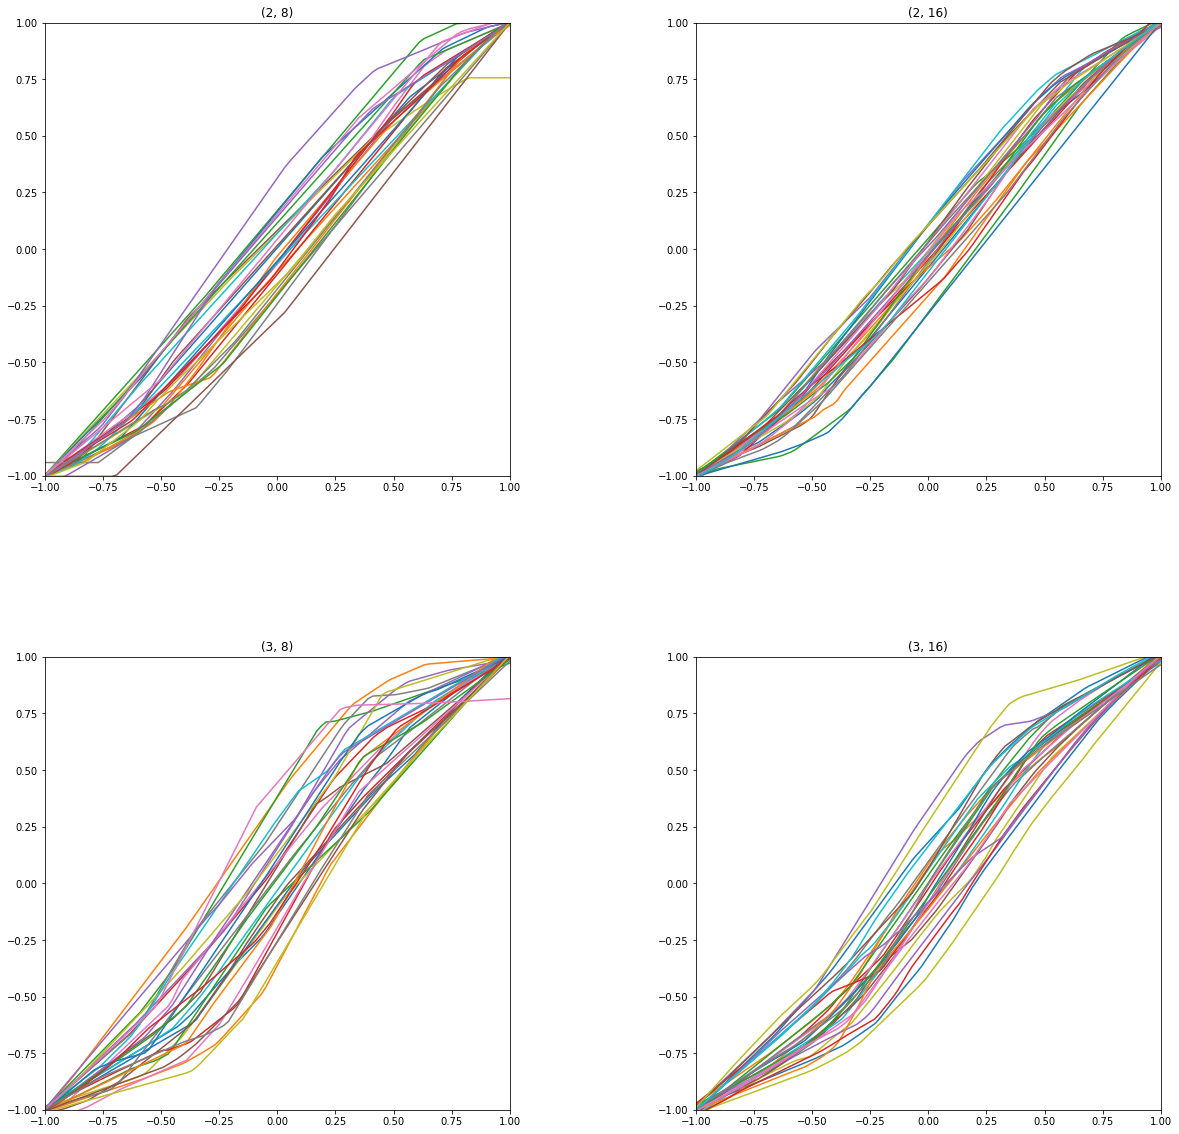

In [15]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plot_idx = 1

# for key, outputs in results.items():
for key in sorted(results.keys()):
    outputs = results[key]
    ax = fig.add_subplot(len(num_l_list), len(hidden_s_list), plot_idx)

    for output in outputs:
        mean, var = output[:,0], output[:,1]
        var = softplus(var)
        std = torch.sqrt(var)
        ax.plot(in_betw.cpu().flatten(), mean.cpu().flatten())
#         ax.fill_between(in_betw.cpu().flatten(), (mean-std).cpu().flatten(), (mean+std).cpu().flatten())
#         ax.plot(in_betw.cpu(), output.cpu())
    ax.set_ylim(-1,1)
    ax.set_xlim(-1,1)
    ax.set_title(key)
    plot_idx+=1
plt.show()

## Plot ensemble mean and uncertainty

In [31]:
in_betw[0].item()

-10.0

In [35]:
zero_idx = None
for idx in range(in_betw.shape[0] - 1):
    if in_betw[idx].item() < 0. and in_betw[idx+1].item() >= 0.:
        zero_idx = idx + 1
        break
print(zero_idx)

500


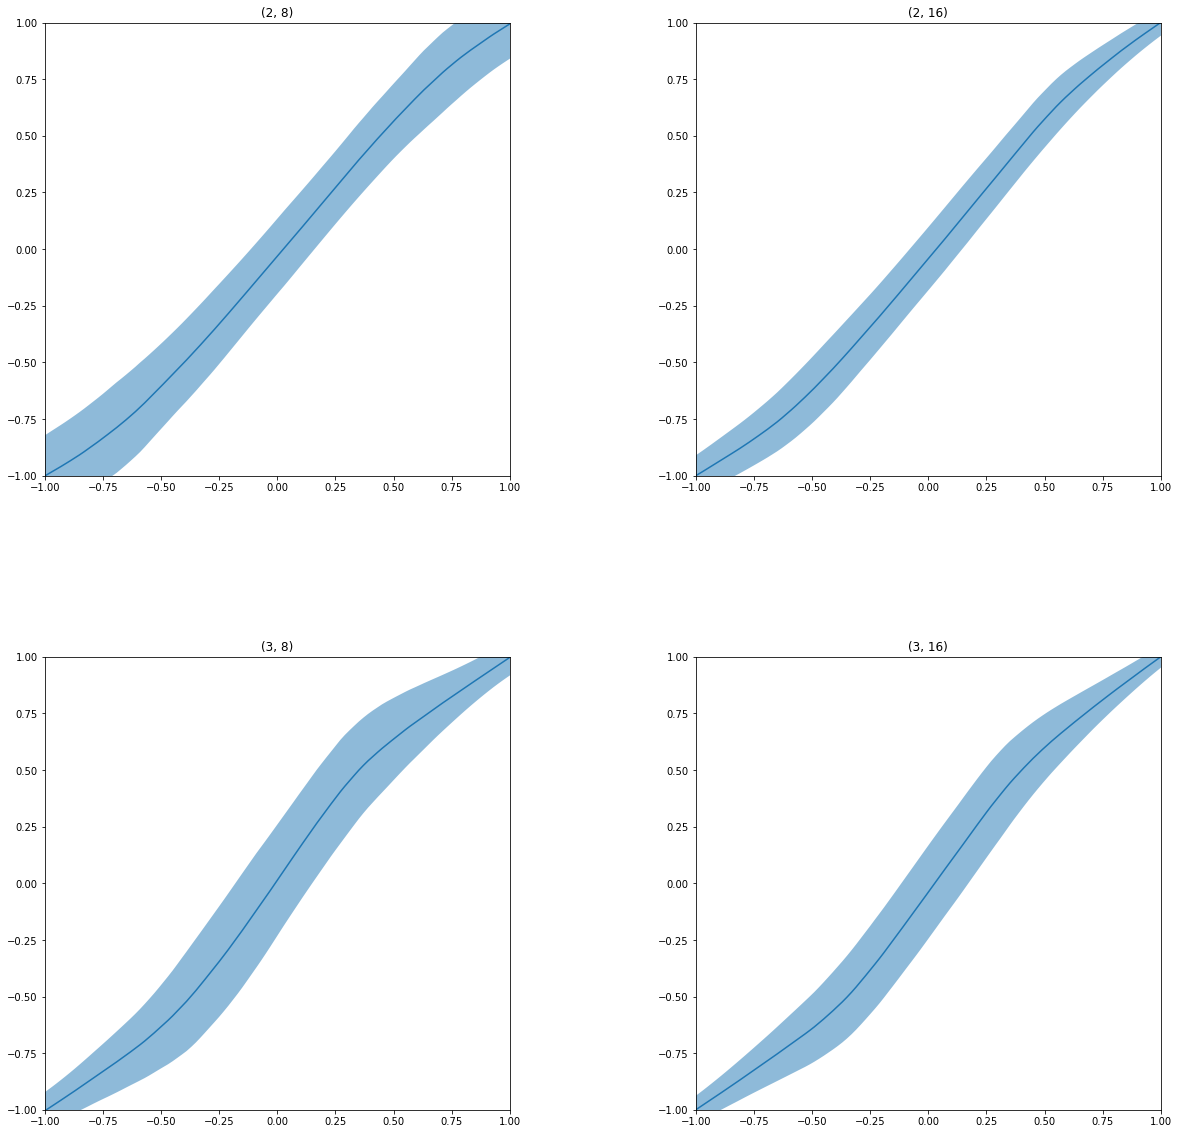

In [38]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
plot_idx = 1

# save means and vars for when x = 0
value_zero = {}
for key in sorted(results.keys()):
    value_zero[key] = {}
    outputs = results[key]
    ax = fig.add_subplot(len(num_l_list), len(hidden_s_list), plot_idx)

    model_arch_means = []
    model_arch_vars = []
    for output in outputs:
        mean, var = output[:,0], output[:,1]
        var = softplus(var)
        std = torch.sqrt(var)
        model_arch_means.append(mean.view(-1,1))
        model_arch_vars.append(var.view(-1,1))
#     import pdb; pdb.set_trace() 
    
    value_zero[key]['mean'] = [x[zero_idx].item() for x in model_arch_means]
    value_zero[key]['var'] = [x[zero_idx].item() for x in model_arch_vars]
    
    model_arch_ens_mean = torch.mean(torch.cat(model_arch_means, dim=1), dim=1)
    ens_var_term_1 = torch.cat(model_arch_means, dim=1)**2
    ens_var_term_2 = torch.cat(model_arch_vars, dim=1)
    ens_var_term_3 = torch.mean(ens_var_term_1 + ens_var_term_2, dim=1)
    model_arch_ens_var = ens_var_term_3 - model_arch_ens_mean**2
    model_arch_ens_std = torch.sqrt(model_arch_ens_var)
    
    ax.plot(in_betw.cpu().flatten(), model_arch_ens_mean.cpu().flatten())
    ax.fill_between(in_betw.cpu().flatten(), 
                    (model_arch_ens_mean-model_arch_ens_std).cpu().flatten(), 
                    (model_arch_ens_mean+model_arch_ens_std).cpu().flatten(),
                   alpha = 0.5)
#         ax.plot(in_betw.cpu(), output.cpu())
    ax.set_ylim(-1,1)
    ax.set_xlim(-1,1)
    ax.set_title(key)
    plot_idx+=1
plt.show()

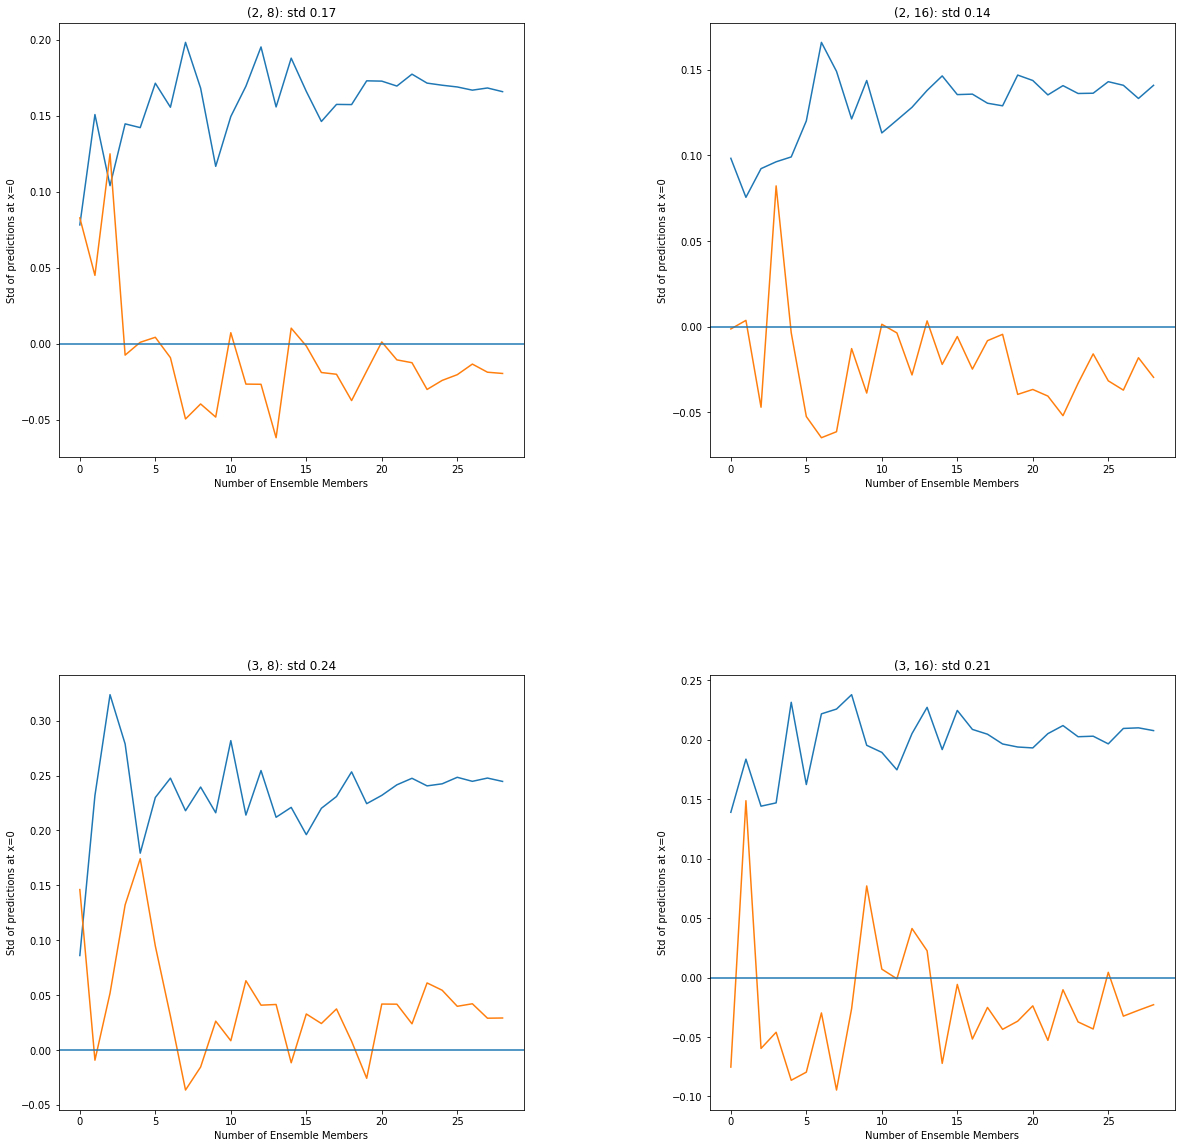

In [50]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
plot_idx = 1

for key, values in value_zero.items():
    mean_arr = np.array(values['mean'])
    var_arr = np.array(values['var'])
    
    means = []
    stds = []
    for i in range(1,len(nets)):
        rand_subset_idx = np.random.choice(mean_arr.size, size=i, replace=False)
        subset_means = mean_arr[rand_subset_idx]
        subset_vars = var_arr[rand_subset_idx]
        
        subset_mean = np.mean(subset_means)
        subset_var = np.mean(subset_vars + subset_means**2) - subset_mean**2
        subset_std = np.sqrt(subset_var)
        
        means.append(subset_mean)
        stds.append(subset_std)
    ax = fig.add_subplot(len(num_l_list), len(hidden_s_list), plot_idx)
    ax.plot(stds)
    ax.plot(means)
    ax.axhline(0)
    ax.set_title('{0}: std {1:.2f}'.format(key, stds[-1]))
    ax.set_xlabel('Number of Ensemble Members')
    ax.set_ylabel('Std of predictions at x=0')
    plot_idx+=1

In [ ]:
fig = plt.figure(figsize=(20,20))
fig.subplots_adjust(hspace=0.5, wspace=0.4)
plot_idx = 1

# for key,nets in saved_models.items():
for key in sorted(saved_models.keys()):
    nets = saved_models[key]
    with torch.no_grad():
        f_0 = np.array([x(torch.tensor([0.0])).numpy() for x in nets if x is not None])
    means = []
    stds = []
    for i in range(len(nets)):
        subset_f_0 = f_0[np.random.choice(f_0.shape[0], size=i),:]
        means.append(np.mean(subset_f_0))
        stds.append(np.std(subset_f_0))
#         print('{0} members | mean: {1:.2f}, std: {2:.2f}'.format(i, np.mean(subset_f_0), np.std(subset_f_0)))
    
    value_zero[key] = {'means':means, 'stds':stds}
    ax = fig.add_subplot(len(num_l_list), len(hidden_s_list), plot_idx)
    ax.plot(stds)
    ax.set_title('{0}: std {1:.2f}'.format(key, stds[-1]))
    ax.set_xlabel('Number of Ensemble Members')
    ax.set_ylabel('Std of predictions at x=0')
    plot_idx+=1

### Modify with extra point

In [ ]:
lr = 1e-2
thresh = 1e-4
sample_ens = [vanilla_nn(hidden_size=50, num_layers=3).to(device) for x in range(30)]
sample_opts = [optim.Adam(x.parameters(), lr=lr) for x in sample_ens]
extra_point_X = torch.tensor([[-1],[0],[1]]).float()
extra_point_y = torch.tensor([[-1],[0],[1]]).float()
# extra_point_X = torch.tensor([[0]]).float()
# extra_point_y = torch.tensor([[0]]).float()
extra_point_X = torch.tensor(np.concatenate([np.linspace(-10, -1, 100), np.linspace(1, 5, 200)]).reshape(-1,1)).float()
extra_point_y = torch.sin(extra_point_X)

In [ ]:
extra_point_X.shape

In [ ]:
ens_200 = deepcopy(sample_ens)

In [ ]:
extra_point_X = extra_point_X.to(device)
extra_point_y = extra_point_y.to(device)

need_training = [i for i in range(len(sample_ens))]
prev_need_training = deepcopy(need_training)
same_list_count = 0

for epoch in tqdm(range(10000)):
    for idx in need_training:
        sample_opts[idx].zero_grad()
        sample_pred = sample_ens[idx](extra_point_X)
        loss = criterion(sample_pred, extra_point_y)
        if loss.item() < thresh:
            print('removing {}, {} nets left'.format(idx, len(need_training)-1))
            need_training.remove(idx)
            continue

        loss.backward()
        sample_opts[idx].step()
    prev_need_training = deepcopy(need_training)
    

In [ ]:
for model in sample_ens:
    print((model(extra_point_X)-extra_point_y)**2)

In [ ]:
in_betw = torch.linspace(-20,20, 10000).view(-1,1).to(device)

In [ ]:
with torch.no_grad():
    for model in sample_ens:
        sample_outputs = model(in_betw)
        plt.plot(in_betw.cpu(), sample_outputs.cpu())
# plt.xlim(-1,1)
# plt.ylim(-1,1)
fig = plt.gcf()
fig.set_size_inches(20,10)

In [ ]:
with torch.no_grad():
    for model in ens_200:
        sample_outputs = model(in_betw)
        plt.plot(in_betw, sample_outputs)
# plt.xlim(-1,1)
# plt.ylim(-1,1)
fig = plt.gcf()
fig.set_size_inches(20,10)

In [ ]:
with torch.no_grad():
    for idx in range(len(nets)):
        print(nets[idx](torch.tensor([[-1.0], [1.0]])))

In [ ]:
with torch.no_grad():
    outputs = [x(in_betw) for x in nets]
    
for output in outputs:
    plt.plot(in_betw.numpy(), output.numpy())
plt.xlim(-1,1)
plt.ylim(-1,1)

In [ ]:
with torch.no_grad():
    f_0 = np.array([x(torch.tensor([0.0])).numpy() for x in nets])
print('mean: {0:.2f}, std: {1:.2f}'.format(np.mean(f_0), np.std(f_0)))

In [ ]:
means = []
stds = []
for i in range(num_nets):
    subset_f_0 = f_0[np.random.choice(f_0.shape[0], size=i),:]
    means.append(np.mean(subset_f_0))
    stds.append(np.std(subset_f_0))
    print('{0} members | mean: {1:.2f}, std: {2:.2f}'.format(i, np.mean(subset_f_0), np.std(subset_f_0)))

In [ ]:
plt.plot(stds)